In [2]:
import nltk
import pandas as pd
import numpy as np


In [4]:
hotstar = pd.read_csv('https://github.com/skathirmani/datasets/raw/master/hotstar.allreviews_Sentiments.csv')
print(hotstar.shape)
hotstar.head()

(5053, 13)


,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,8/10/2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,8/11/2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,8/12/2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,8/11/2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,8/5/2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [9]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...


True

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti = SentimentIntensityAnalyzer()
print(senti.polarity_scores('i love india'))
print(senti.polarity_scores('i LOVE india'))
print(senti.polarity_scores('i love india :)'))

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.169, 'pos': 0.831, 'compound': 0.7125}
{'neg': 0.0, 'neu': 0.122, 'pos': 0.878, 'compound': 0.802}


In [18]:
print(senti.polarity_scores('i love india')['compound'])

0.6369


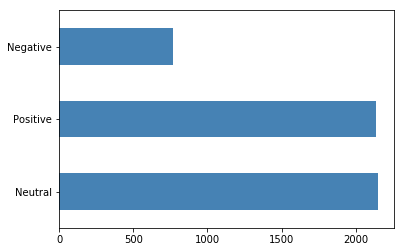

In [31]:
%matplotlib inline
def get_sentiment_score(review):
    compound_score = senti.polarity_scores(review)['compound']
    return compound_score

def get_sentiment(score):
    if score > 0.25:
        return 'Positive'
    elif score < -0.25:
        return 'Negative'
    else:
        return 'Neutral'

hotstar['sentiment_score'] = hotstar['Reviews'].apply(get_sentiment_score)
hotstar['sentiment_vader'] = hotstar['sentiment_score'].apply(get_sentiment)
#hotstar['sentiment_score'].plot.hist()
hotstar['sentiment_vader'].value_counts().plot.barh(color='steelblue')

In [32]:
hotstar['date'] = pd.to_datetime(hotstar['Created_Date'])
hotstar['date'].min(), hotstar['date'].max()

(Timestamp('2017-08-04 00:00:00'), Timestamp('2017-08-13 00:00:00'))

Text(0.5,1,'Sentiment Analysis on Hotstar Reviews')

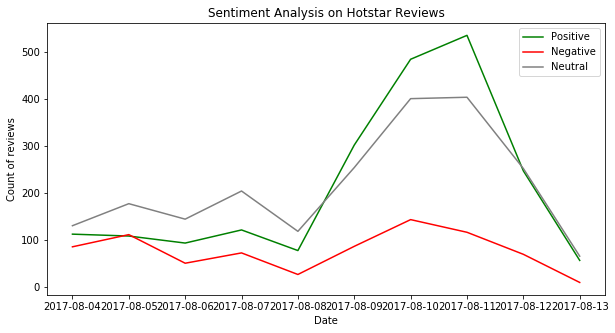

In [43]:
sent_trend = hotstar.groupby(['date', 'sentiment_vader']).size()
sent_trend = sent_trend.reset_index()
sent_trend = sent_trend.rename(columns={0: 'count'})

pos_rows = sent_trend[sent_trend['sentiment_vader'] == 'Positive']
neg_rows = sent_trend[sent_trend['sentiment_vader'] == 'Negative']
neu_rows = sent_trend[sent_trend['sentiment_vader'] == 'Neutral']

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(pos_rows['date'], pos_rows['count'], color='green')
plt.plot(neg_rows['date'], neg_rows['count'], color='red')
plt.plot(neu_rows['date'], neu_rows['count'], color='gray')
plt.legend(['Positive', 'Negative', 'Neutral'])
plt.xlabel('Date')
plt.ylabel('Count of reviews')
plt.title('Sentiment Analysis on Hotstar Reviews')

## Supervised Sentiment Anlaysis

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score

stop_words = nltk.corpus.stopwords.words('english')
stop_words = list(np.setdiff1d(stop_words, ['not']))
junk_words = []

stop_words.extend(junk_words)
stemmer = nltk.PorterStemmer()

docs = hotstar['Reviews'].fillna('').str.lower().str.replace('[^a-z ]', '')
docs_clean = docs.apply(lambda v: ' '.join([stemmer.stem(word) for word in v.split(' ') \
                                            if word not in stop_words]))

train, test = train_test_split(docs_clean, test_size=0.3, random_state=100)

cv = CountVectorizer()
cv.fit(train)
train_x = cv.transform(train)
test_x = cv.transform(test)

train_y = hotstar.loc[train.index]['Sentiment_Manual']
test_y = hotstar.loc[test.index]['Sentiment_Manual']

adaboost_model = RandomForestClassifier(n_estimators=300, random_state=100)
adaboost_model.fit(train_x, train_y)
pred_class = adaboost_model.predict(test_x)
accuracy_score(test_y, pred_class)

0.7486807387862797

In [63]:
accuracy_score(hotstar['Sentiment_Manual'], hotstar['sentiment_vader'])

0.5513556303186226

# Web Scraping

In [ ]:
url = 'https://bit.ly/2QjOT2Z'

In [64]:
import os
os.getcwd()

'C:\\Users\\admin'

In [67]:
#!pip install selenium
from selenium import webdriver
browser = webdriver.Chrome('chromedriver.exe')

In [69]:
url = 'https://bit.ly/2QjOT2Z'
browser.get(url)

In [71]:
parent_tags = browser.find_elements_by_css_selector('li.job-listing')
len(parent_tags)

25

In [85]:
import bs4

In [89]:
jobs = pd.DataFrame()
for job in parent_tags:
    title_tag = job.find_element_by_css_selector('span.job-title-text')
    title = title_tag.get_attribute('innerHTML').replace(
        '<b>', '').replace('</b>', '')
    
    company_tag = job.find_element_by_css_selector('span.company-name-text')
    company = company_tag.get_attribute('innerHTML')
    
    location_tag = job.find_element_by_css_selector('span.job-location')
    location_tag = location_tag.find_element_by_css_selector('span')
    location = location_tag.get_attribute('innerHTML')
    
    description_tag = job.find_element_by_css_selector('div.job-description')
    description = description_tag.get_attribute('innerHTML')
    description = bs4.BeautifulSoup(description, 'html.parser').text
    # rep_str = '...<span class="job-attribution"> </span>'
    # description = description.replace(rep_str, '')
    
    curr_job = {'title': title,
                'company': company,
                'location': location,
                'description': description}
    jobs = jobs.append(curr_job, ignore_index=True)

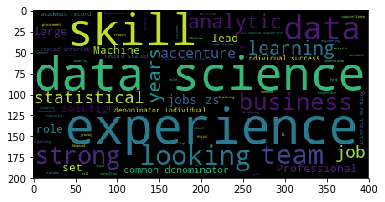

In [95]:
from wordcloud import WordCloud
wc = WordCloud().generate(' '.join(jobs['description']))
plt.figure(figsize=(6,12))
plt.imshow(wc)

# Text Summarization

In [98]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [101]:
url = 'https://www.livemint.com/Companies/b4LtGm53W966uRNUiVQQKL/Maggi-case-Supreme-Court-revives-classaction-suit-against.html?utm_campaign=fullarticle&utm_medium=referral&utm_source=inshorts'
browser.get(url)

In [102]:
div_tag = browser.find_element_by_css_selector('div.content')
para_tags = div_tag.find_elements_by_css_selector('p')
len(para_tags)

12

In [106]:
sentences = ''
for para in para_tags:
    para_text = para.get_attribute('innerHTML')
    sentences = sentences + ' ' + para_text
    sentences = bs4.BeautifulSoup(sentences, 'html.parser').text
sentences[:10]

' New Delhi'

In [108]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [116]:
parser = PlaintextParser(sentences, Tokenizer('english'))

summarizer = LexRankSummarizer()
summarized_sentences = summarizer(parser.document, 3)

for sentence in summarized_sentences:
    print(sentence)
    print('------------------')

New Delhi: In a setback to Nestle India Ltd, the Supreme Court on Thursday lifted a stay on the proceedings of a class-action suit filed by the central government against the maker of Maggi noodles in the apex consumer court.
------------------
The National Consumer Disputes Redressal Commission (NCDRC) can now continue proceedings against Nestle India, based on  the results of tests of Maggi noodle samples conducted by the Central Food Technological Research Institute (CFTRI) in Mysuru.
------------------
Nestle said that Maggi, which once enjoyed a 75% share of the market before the ban, clawed back to 60% in 2016.
------------------
